-- PROGRAMMING FOR DATA ANALYTICS : XBOOST__


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__



# XGBoost Regression Analysis Of Solar and Weather

XGBoost or eXtreme Gradient Boosting is a ensemble learning method , similar to random forest. 

[XGBOOST](https://xgboost.readthedocs.io/en/stable/)
(youtube random forest cs xgboost)[https://www.youtube.com/watch?v=Vp_Js6RLcc0]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do XGBoost regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Configure File Paths and Solar Parameters

Sets up the directory paths for data and models used throughout the analysis:
- Determines the notebook's current directory
- Defines paths to training, testing, and processed data
- Configures solar panel parameters (19 panels, 8,360W total capacity)
- Sets location coordinates for Bettystown, Ireland


In [2]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


## Set Nighttime Threshold

Filters out nighttime data where Clear Sky GHI ≤ 50 W/m². 

Only daytime data with meaningful solar radiation is used for training the model.


In [3]:
hourly_nightly_threshold = 50

# XGBoost Regression Analysis Of Solar and Weather

[XBOOST](https://xgboost.readthedocs.io/en/stable/)

In [4]:
try:
    import xgboost as xgb
except:
    %pip install xgboost
    import xgboost as xgb

## Define Data File Paths

Specifies the file paths for:
- Enriched features dataset with Copernicus weather data
- Weather data from multiple sources
- Training and testing datasets split by date


In [5]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [6]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

## Display Dataset Structure

Shows the column names and data types of the training dataset to verify the data loaded correctly.


In [7]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Display All Column Names

Prints all column names in the training dataframe for reference.

Useful for selecting features and understanding available data.


In [8]:
# print out all columns in the dataframe
print("Columns in the training dataframe:")
for col in df_daytime_train.columns:
    print(col)

Columns in the training dataframe:
index
DateTime
PV(W)
Temperature(C)
Humidity(%)
Sunshine Duration
Condition Code
Precipitation(mm)
Dew Point(C)
Wind Direction(deg)
Wind Speed(m/s)
Wind Gust(m/s)
Pressure(hPa)
Snow Depth(cm)
level1_clear
level1_cloudy
level1_fair
level1_fog
level1_freezing_rain
level1_heavy_rain
level1_heavy_rain_shower
level1_heavy_sleet
level1_light_rain
level1_overcast
level1_rain
level1_rain_shower
level1_sleet
level1_sleet_shower
level1_thunderstorm
level2_good_visibility
level2_moderate_visibility
level2_poor_visibility
level2_precipitation
level2_severe_weather
# Observation period
TOA
Clear sky GHI
Clear sky BHI
Clear sky DHI
Clear sky BNI
GHI
BHI
DHI
BNI
Reliability,
Time
Date
POA_Pane_I(W/m^2)
POA_Pane_II(W/m^2)
POAC_Pane_I(W/m^2)
POAC_Pane_II(W/m^2)
Power_Pane_I(W)
Power_Pane_II(W)
Power_ClearSky_Pane_I(W)
Power_ClearSky_Pane_II(W)
Total_Power_Output(W)
Total_Power_ClearSky_Output(W)
WeekOfYear
Month_Sin
DayOfYear_Sin
HourOfDay_Sin
Month_Cos
HourOfDay_Cos


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [9]:
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
#target_col = 'Clearsky_Index'
target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
#feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
# Lag Features



#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

# Optional feature candidates (commented out by default)
#feature_cols.append('DateTime')
#feature_cols.append('PV(W)')
#feature_cols.append('GHI')
#feature_cols.append('BHI')
#feature_cols.append('DHI')
#feature_cols.append('BNI')
#feature_cols.append('Reliability,')
#feature_cols.append('Time')
#feature_cols.append('Date')
#feature_cols.append('POA_Pane_I(W/m^2)')
#feature_cols.append('POA_Pane_II(W/m^2)')
#feature_cols.append('POAC_Pane_I(W/m^2)')
#feature_cols.append('POAC_Pane_II(W/m^2)')
#feature_cols.append('Power_Pane_I(W)')
#feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
#feature_cols.append('Total_Power_Output(W)')
#feature_cols.append('WeekOfYear')

#feature_cols.append('Hour')
#feature_cols.append('Temp_Momentum')
#feature_cols.append('Humidity_Momentum')
#feature_cols.append('WindSpeed_Momentum')
#feature_cols.append('Total_Power_ClearSky_Output(W)_Momentum')
feature_cols.append('Temp_Lag1')
feature_cols.append('Humidity_Lag1')
feature_cols.append('WindSpeed_Lag1')
feature_cols.append('Dew Point(C)_Lag1')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag1')
feature_cols.append('Temp_Lag24')
feature_cols.append('Humidity_Lag24')
feature_cols.append('WindSpeed_Lag24')
feature_cols.append('Dew Point(C)_Lag24')
feature_cols.append('Total_Power_ClearSky_Output(W)_Lag24')
#feature_cols.append('Clearsky_Index')
#feature_cols.append('PV(W)_error')
#feature_cols.append('PV(W)_error_index')
#feature_cols.append('Wind Gust(m/s)')
#feature_cols.append('Snow Depth(cm)')

# Individual level1 categorical toggles (use instead of level1_features helper)
#feature_cols.append('level1_clear')
#feature_cols.append('level1_cloudy')
#feature_cols.append('level1_fair')
#feature_cols.append('level1_fog')
#feature_cols.append('level1_freezing_rain')
#feature_cols.append('level1_heavy_rain')
#feature_cols.append('level1_heavy_rain_shower')
#feature_cols.append('level1_heavy_sleet')
#feature_cols.append('level1_light_rain')
#feature_cols.append('level1_overcast')
#feature_cols.append('level1_rain')
#feature_cols.append('level1_rain_shower')
#feature_cols.append('level1_sleet')
#feature_cols.append('level1_sleet_shower')
#feature_cols.append('level1_thunderstorm')

print(f"\nTesting XGBoost Regressor with target: {target_col} and features: {feature_cols}")



Testing XGBoost Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Dew Point(C)_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'Temp_Lag24', 'Humidity_Lag24', 'WindSpeed_Lag24', 'Dew Point(C)_Lag24', 'Total_Power_ClearSky_Output(W)_Lag24']


## Prepare Training and Testing Data

Creates the feature matrices (X) and target vectors (y) for both training and testing datasets.

Splits the data into independent variables (features) and dependent variable (target) for model training and evaluation.


In [10]:

print(f"\nTesting XGBoost Regressor with target: {target_col} and features: {feature_cols}")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# Save test and training x and y to feather files
# This allows later analysis without needing to redo the train test split
X_train.to_pickle(f"{TRAIN_DATA_DIR}/X_train_test_no_{test_no}.pickle")
y_train.to_pickle(f"{TRAIN_DATA_DIR}/y_train_test_no_{test_no}.pickle")
X_test.to_pickle(f"{TRAIN_DATA_DIR}/X_test_test_no_{test_no}.pickle")
y_test.to_pickle(f"{TRAIN_DATA_DIR}/y_test_test_no_{test_no}.pickle")
# Also put test no , name and notes in a dataframe and save as feather
test_info_df = pd.DataFrame({
    "Test No": [test_no],
    "Test Name": [test_name],
    "Notes": [notes],
    'target_col': [target_col],
    'feature_cols': [feature_cols]
})
test_info_df.to_feather(f"{TRAIN_DATA_DIR}/test_info_test_no_{test_no}.pickle")



Testing XGBoost Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', 'Temp_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1', 'Dew Point(C)_Lag1', 'Total_Power_ClearSky_Output(W)_Lag1', 'Temp_Lag24', 'Humidity_Lag24', 'WindSpeed_Lag24', 'Dew Point(C)_Lag24', 'Total_Power_ClearSky_Output(W)_Lag24']
X_train shape: (2192, 30)
y_train shape: (2192,)
X_test shape: (2194, 30)
y_test shape: (2194,)


__XBOOST Hyper parameter tuning__

This tries and finds the best parameters for hyper tuning.  

(SCIKIT Learn)[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html]

In [11]:
try:
    import optuna
except:
    print("Optuna not found, installing...")
    %pip install optuna
    priint("Optuna installed successfully.")
    import optuna

__Tuning Hyper Parameters with Optuna__

"Gemini was prompted : Is there a way of automatically tuning the xboost by adjusting the features"

(Optuna)[https://optuna.org/]


In [12]:
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print(study.best_params)

[I 2026-01-08 08:01:16,384] A new study created in memory with name: no-name-493f289b-a75b-40ba-9cb0-8b8594007bd3
[I 2026-01-08 08:01:17,181] Trial 0 finished with value: 695.2118661056712 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.0335993578472537, 'subsample': 0.831335913888385, 'colsample_bytree': 0.6577885187976544}. Best is trial 0 with value: 695.2118661056712.
[I 2026-01-08 08:01:17,337] Trial 1 finished with value: 708.0234812626794 and parameters: {'n_estimators': 261, 'max_depth': 4, 'learning_rate': 0.0973569679695923, 'subsample': 0.6420253833116024, 'colsample_bytree': 0.506142773208462}. Best is trial 0 with value: 695.2118661056712.
[I 2026-01-08 08:01:18,341] Trial 2 finished with value: 679.7033830420503 and parameters: {'n_estimators': 614, 'max_depth': 8, 'learning_rate': 0.019605200687488403, 'subsample': 0.6714851716651389, 'colsample_bytree': 0.5461204811738039}. Best is trial 2 with value: 679.7033830420503.
[I 2026-01-08 08:01:18,63

{'n_estimators': 487, 'max_depth': 7, 'learning_rate': 0.012751121015154826, 'subsample': 0.7038816779670508, 'colsample_bytree': 0.529543386443093}


## Initialize XGBoost Model

Creates an XGBoost Regressor with specified hyperparameters:
- **n_estimators**: Number of boosting rounds (trees)
- **learning_rate**: Step size shrinkage to prevent overfitting
- **max_depth**: Maximum tree depth
- **subsample**: Fraction of samples used for each tree

XGBoost builds an ensemble of decision trees sequentially.


In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define a wider grid of options
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5]
}

# Run the random search (this may take a minute or two)
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Best params found: {random_search.best_params_}")
# Use these params in your final model
xgb_model = random_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params found: {'subsample': 0.8, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


## Initialize XGBoost Model

Creates an XGBoost Regressor with specified hyperparameters:
- **n_estimators**: Number of boosting rounds (trees)
- **learning_rate**: Step size shrinkage to prevent overfitting
- **max_depth**: Maximum tree depth
- **subsample**: Fraction of samples used for each tree

XGBoost builds an ensemble of decision trees sequentially.


In [14]:
# Initialize XGBoost Regressor with optimized hyperparameters
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Step size shrinkage used to prevent overfitting
# max_depth: Maximum depth of a tree
# subsample: Fraction of samples used for fitting the individual base learners
# colsample_bytree: Fraction of features used when constructing each tree
# reg_alpha: L1 regularization term on weights
# reg_lambda: L2 regularization term on weights
# Initialize XGBoost with a higher max estimator count
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,   # Reduced from 0.05 to learn slower and more robustly
    max_depth=4,          # Reduced from 6 to prevent memorizing data
    min_child_weight=5,   # Increased to prevent isolating outliers
    subsample=0.6,        # Only use 60% of rows per tree
    colsample_bytree=0.7, # Only use 70% of features per tree
    reg_alpha=0.1,        # L1 Regularization (Lasso)
    reg_lambda=1.0,       # L2 Regularization (Ridge)
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Pass the test set as the validation set
# verbose=100 prints progress every 100 trees
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

[0]	validation_0-rmse:1166.91712	validation_1-rmse:1103.71150


[100]	validation_0-rmse:764.24908	validation_1-rmse:789.93298
[200]	validation_0-rmse:633.13475	validation_1-rmse:717.90649
[300]	validation_0-rmse:579.07659	validation_1-rmse:698.78238
[400]	validation_0-rmse:545.10532	validation_1-rmse:693.03063
[500]	validation_0-rmse:518.24878	validation_1-rmse:690.26223
[600]	validation_0-rmse:497.25645	validation_1-rmse:688.35319
[700]	validation_0-rmse:476.47935	validation_1-rmse:686.05285
[800]	validation_0-rmse:457.16967	validation_1-rmse:684.19577
[900]	validation_0-rmse:441.52515	validation_1-rmse:683.28839
[1000]	validation_0-rmse:425.74667	validation_1-rmse:682.42236
[1100]	validation_0-rmse:411.71972	validation_1-rmse:681.70951
[1153]	validation_0-rmse:405.68981	validation_1-rmse:681.91933


## Handle Target Variable Transformation

Checks if the target variable needs inverse transformation after scaling.

For PV(W), no inverse transformation is needed as it's used in its original scale.


In [15]:

print(f"Target Column {target_col}")
# Depending on target column, inverse transform if necessary
if target_col in ['PV(W)']:
    print("No inverse transformation needed for PV(W)")
    y_train_pvw_pred = y_train_pred
    y_train_pvw = y_train
    y_test_pvw_pred = y_test_pred
    y_test_pvw = y_test
elif target_col in ['PV(W)_error']:
    print("Inverse transforming PV(W)_error to PV(W)")
    y_train_pvw_pred = y_train_pred + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test + X_test['Total_Power_ClearSky_Output(W)']
if target_col in ['Clearsky_Index']:   
    print("Inverse transforming Clearsky_Index to PV(W)")
    y_train_pvw_pred = y_train_pred * X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train * X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred * X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test * X_test['Total_Power_ClearSky_Output(W)']
elif target_col in ['PV(W)_error_index']:
    print("Inverse transforming PV(W)_error_index to PV(W)")
    y_train_pvw_pred = (y_train_pred * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = (y_train * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = (y_test_pred * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = (y_test * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']

# Clip negative predictions to 0
y_train_pvw_pred = y_train_pvw_pred.clip(lower=0)
y_test_pvw_pred = y_test_pvw_pred.clip(lower=0)

Target Column PV(W)_error
Inverse transforming PV(W)_error to PV(W)


__Metrics for Tests 

## Calculate Performance Metrics

Computes evaluation metrics for both training and testing datasets:
- **RMSE** (Root Mean Squared Error): Average prediction error magnitude
- **MAE** (Mean Absolute Error): Average absolute prediction error
- **R² Score**: Proportion of variance explained by the model

These metrics help assess model performance and generalization.


In [16]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


# do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    # Calculate Explained Variance
    explained_var = explained_variance_score(y_true, y_pred)
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score, explained_var
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy, train_explained_var = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy, test_explained_var = calculate_metrics(y_test, y_test_pred)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw, train_explained_var_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw, test_explained_var_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100,
    train_explained_var, test_explained_var
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics {target_col}\n" + mk_string))
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100,
    train_explained_var_pvw, test_explained_var_pvw
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics PV(W)\n" + mk_string))

### XBOOST Regressor Performance Metrics PV(W)_error
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 411.41              | 681.60              |
| MAE          | 305.11              | 502.45              |
| R2           | 0.8772              | 0.6192              |
| N-RMSE (%)   | 6.6591              | 10.8377              |
| N-MAE (%)    | 4.9384              | 7.9891              |
| Accuracy (%) | 120.0961              | 135.6931              |
| Explained Variance | 0.8772         | 0.6212              |


### XBOOST Regressor Performance Metrics PV(W)
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 411.15              | 681.30              |
| MAE          | 304.45              | 501.61              |
| R2           | 0.9164              | 0.7577              |
| N-RMSE (%)   | 7.3174              | 12.1517              |
| N-MAE (%)    | 5.4184              | 8.9468              |
| Accuracy (%) | 82.7685              | 73.6737              |
| Explained Variance | 0.9164         | 0.7590              |


Prediction vs. Actual plot. This is critical to seeing when the model is failing (e.g., is it predicting power at night? Is it underestimating sunny days?).

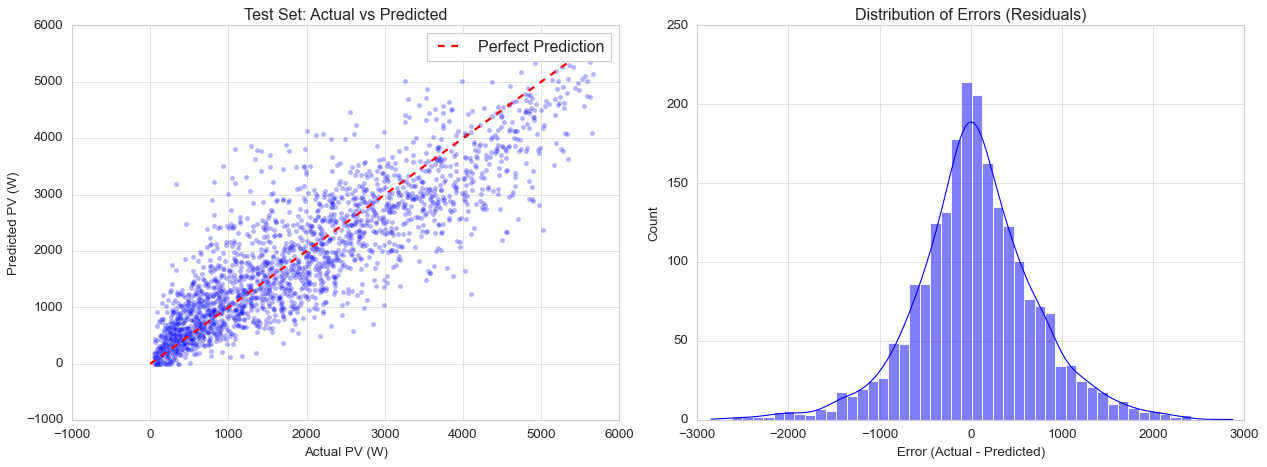

In [17]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot of Actual vs Predicted
sns.scatterplot(x=y_test_pvw, y=y_test_pvw_pred, alpha=0.3, ax=ax[0])
# Add a diagonal red line (Perfect Prediction)
max_val = max(y_test_pvw.max(), y_test_pvw_pred.max())
ax[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax[0].set_xlabel('Actual PV (W)')
ax[0].set_ylabel('Predicted PV (W)')
ax[0].set_title('Test Set: Actual vs Predicted')
ax[0].legend()

# Plot 2: Residuals (Errors) over time or distribution
residuals = y_test_pvw - y_test_pvw_pred
sns.histplot(residuals, kde=True, ax=ax[1], bins=50)
ax[1].set_xlabel('Error (Actual - Predicted)')
ax[1].set_title('Distribution of Errors (Residuals)')

plt.tight_layout()
plt.show()

## Calculate Feature Importance

Extracts feature importance scores from the trained model.

Creates a dataframe sorted by importance to identify the most influential features.


In [18]:
# feature importance plot
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))


                                 Feature  Importance
29  Total_Power_ClearSky_Output(W)_Lag24    0.158618
15                level2_good_visibility    0.136171
1                            Humidity(%)    0.086896
2                      Precipitation(mm)    0.073566
8         Total_Power_ClearSky_Output(W)    0.068777
18                  level2_precipitation    0.068505
16            level2_moderate_visibility    0.037141
21                         Humidity_Lag1    0.035443
4                    Wind Direction(deg)    0.032954
11                         HourOfDay_Sin    0.023299
14                         HourOfDay_Cos    0.022465
24   Total_Power_ClearSky_Output(W)_Lag1    0.021578
13                         DayOfYear_Cos    0.021240
6                          Pressure(hPa)    0.017807
7                           Wind Cooling    0.017422
3                           Dew Point(C)    0.017063
10                         DayOfYear_Sin    0.016798
22                        WindSpeed_Lag1    0.

## Plot Feature Importance

Creates a bar chart showing the top 20 most important features.

Helps understand which variables have the strongest influence on predictions.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



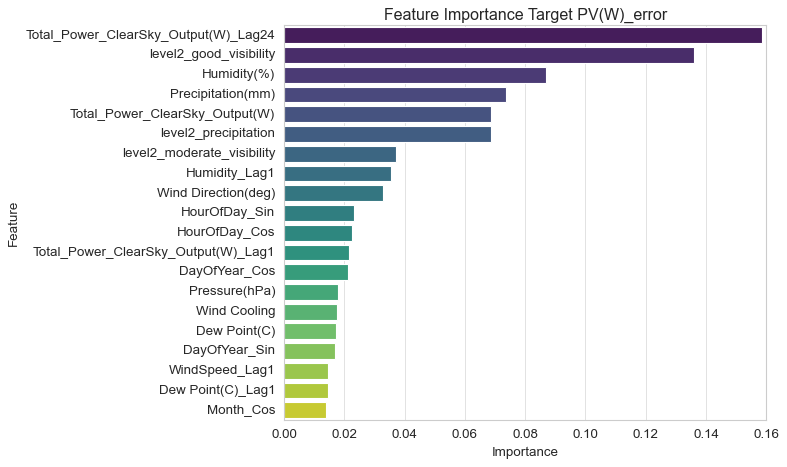

In [19]:

plt.figure(figsize=(10, 6))
plt.title(f'Feature Importance Target {target_col}')
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Visualize Model Performance

Creates plots to visualize model predictions against actual values:
- Scatter plots comparing predicted vs actual values
- Separate plots for training and testing data
- Helps assess model fit and identify potential issues


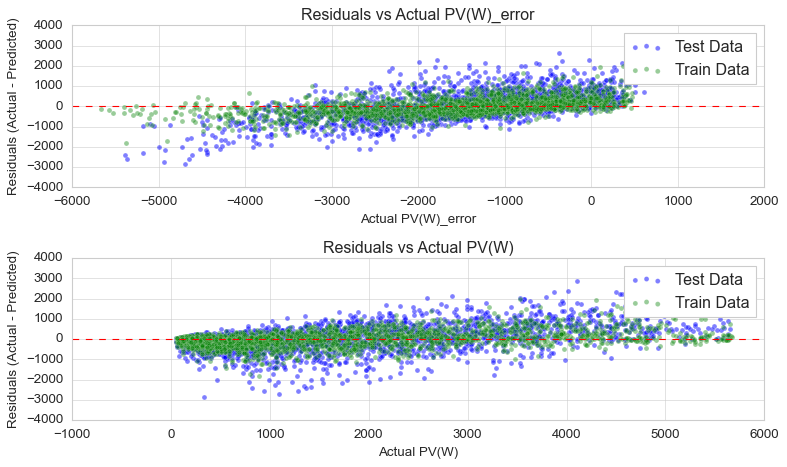

In [20]:
# plot residuals
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax = ax.flatten()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[0])
sns.scatterplot(x=y_train, y=y_train - y_train_pred, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title(f'Residuals vs Actual {target_col}')
ax[0].set_xlabel(f'Actual {target_col}')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test_pvw, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[1])
sns.scatterplot(x=y_train_pvw, y=y_train_pvw - y_train_pvw_pred, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title(f'Residuals vs Actual PV(W)')
ax[1].set_xlabel(f'Actual PV(W)')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.tight_layout()
plt.show()

## Visualize Model Performance

Creates plots to visualize model predictions against actual values:
- Scatter plots comparing predicted vs actual values
- Separate plots for training and testing data
- Helps assess model fit and identify potential issues


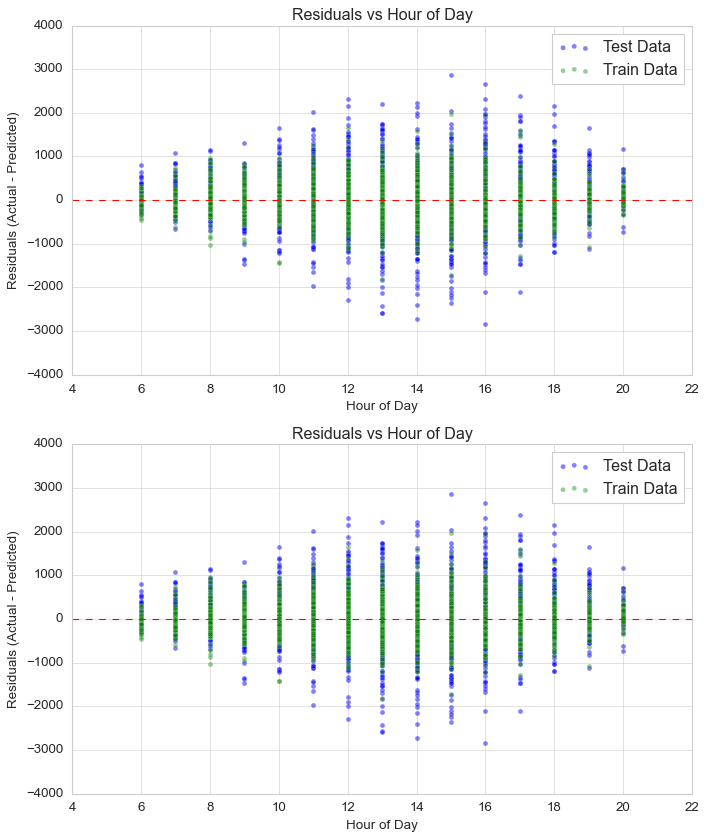

In [21]:
# plot risduals per hour of day
fig, ax = plt.subplots(2,1,figsize=(10,12))
ax = ax.flatten()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[0])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train - y_train_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[1])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train_pvw - y_train_pvw_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title('Residuals vs Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.show()

## Visualize Model Performance

Creates plots to visualize model predictions against actual values:
- Scatter plots comparing predicted vs actual values
- Separate plots for training and testing data
- Helps assess model fit and identify potential issues


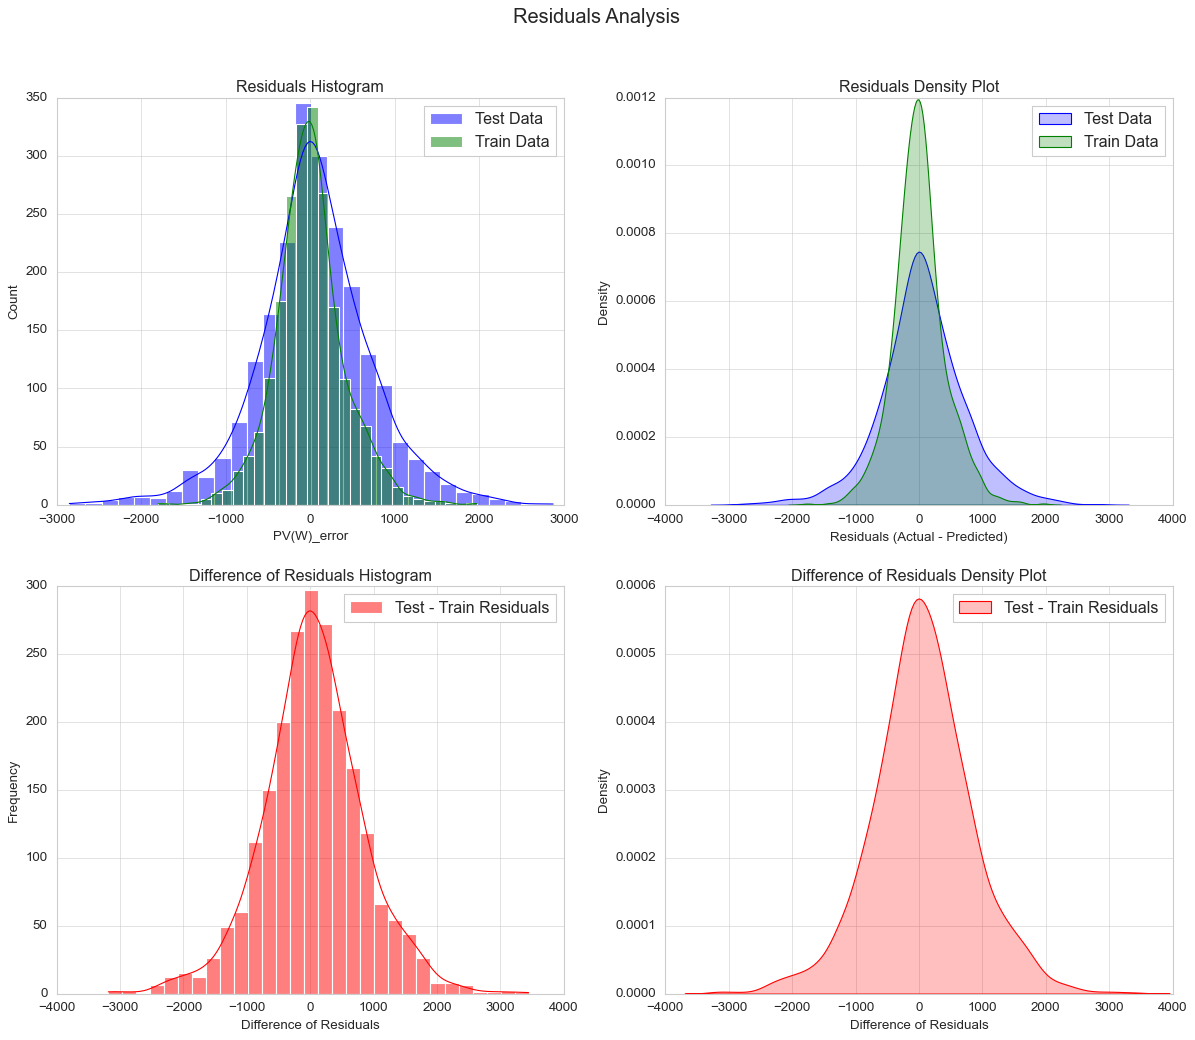

In [22]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

__Visualization: Time-Series Zoom__
Scatter plots are good for overall correlation, but they hide temporal patterns. You need to see if the model captures the "shape" of the day.

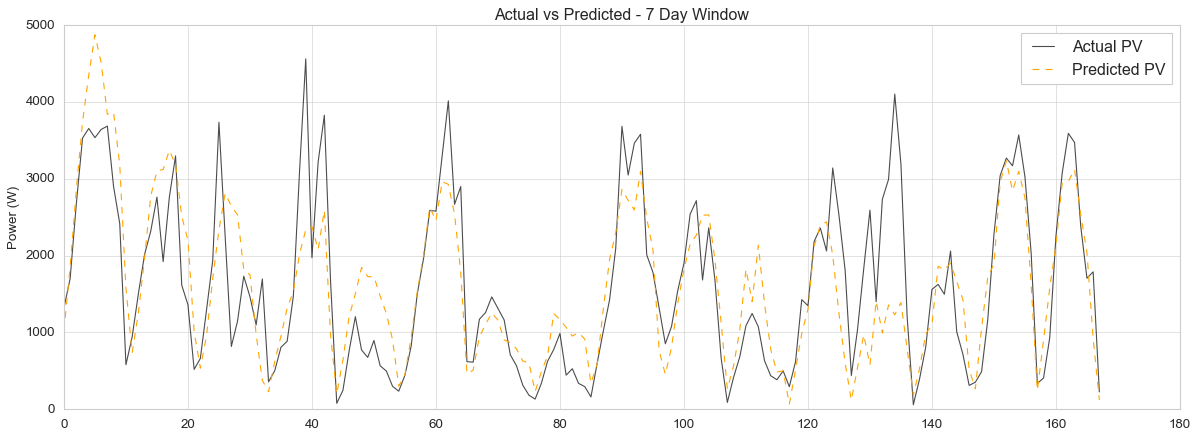

In [23]:
# Create a DataFrame for easy plotting
df_viz = pd.DataFrame({
    'Actual': y_test_pvw,
    'Predicted': y_test_pvw_pred
}).reset_index(drop=True)

# Plot a specific 1-week window (e.g., first 168 hours) to see the daily curve
plt.figure(figsize=(18, 6))
subset = df_viz.iloc[0:168] # First 7 days
plt.plot(subset['Actual'], label='Actual PV', color='black', alpha=0.7)
plt.plot(subset['Predicted'], label='Predicted PV', color='orange', linestyle='--')
plt.title("Actual vs Predicted - 7 Day Window")
plt.ylabel("Power (W)")
plt.legend()
plt.show()

__Error Analysis: Residuals by Hour__   
Does your model consistently under-predict at noon? Or over-predict at sunrise? This plot will tell you.

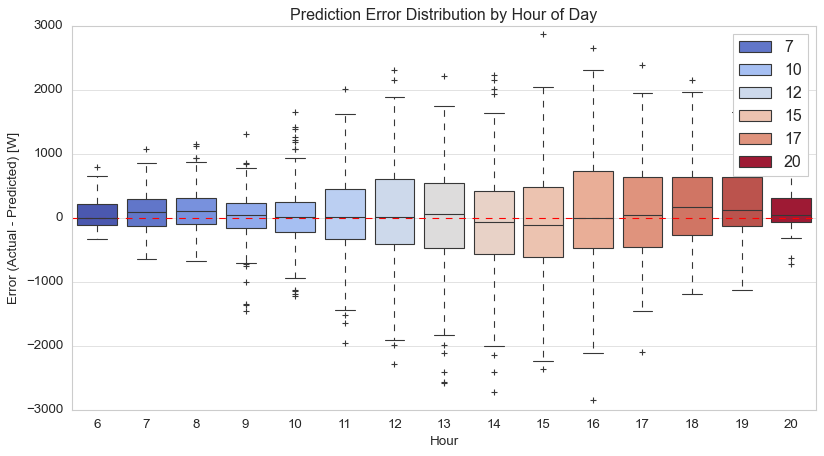

In [24]:
# Extract the residuals
df_results = pd.DataFrame({
    'Actual': y_test_pvw,
    'Predicted': y_test_pvw_pred,
    'Error': y_test_pvw - y_test_pvw_pred,
    'Hour': df_daytime_test.loc[y_test.index, 'Hour']
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='Hour', y='Error', palette='coolwarm',hue='Hour', dodge=False)
plt.axhline(0, color='red', linestyle='--')
plt.title('Prediction Error Distribution by Hour of Day')
plt.ylabel('Error (Actual - Predicted) [W]')
plt.legend()
plt.show()

__Advanced Explainability: SHAP Values_
To understand why the model makes specific predictions (e.g., "Why did it predict low power on a sunny day?"), use SHAP.

## QQ Plot of Residuals

Creates a Quantile-Quantile plot to assess if residuals follow a normal distribution.

Points should lie close to the diagonal line if residuals are normally distributed.


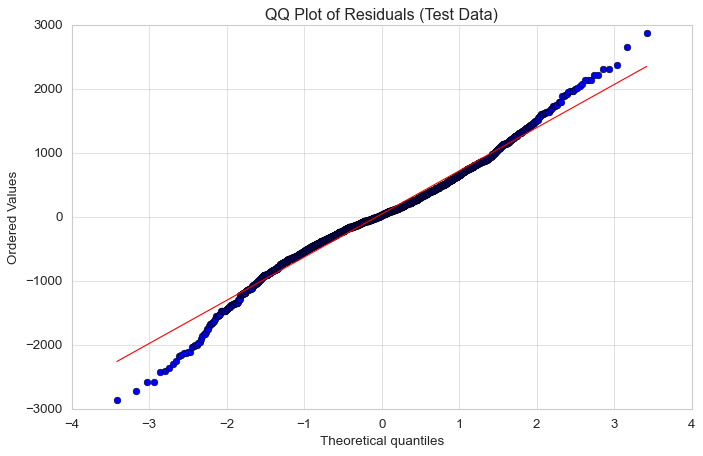

In [25]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


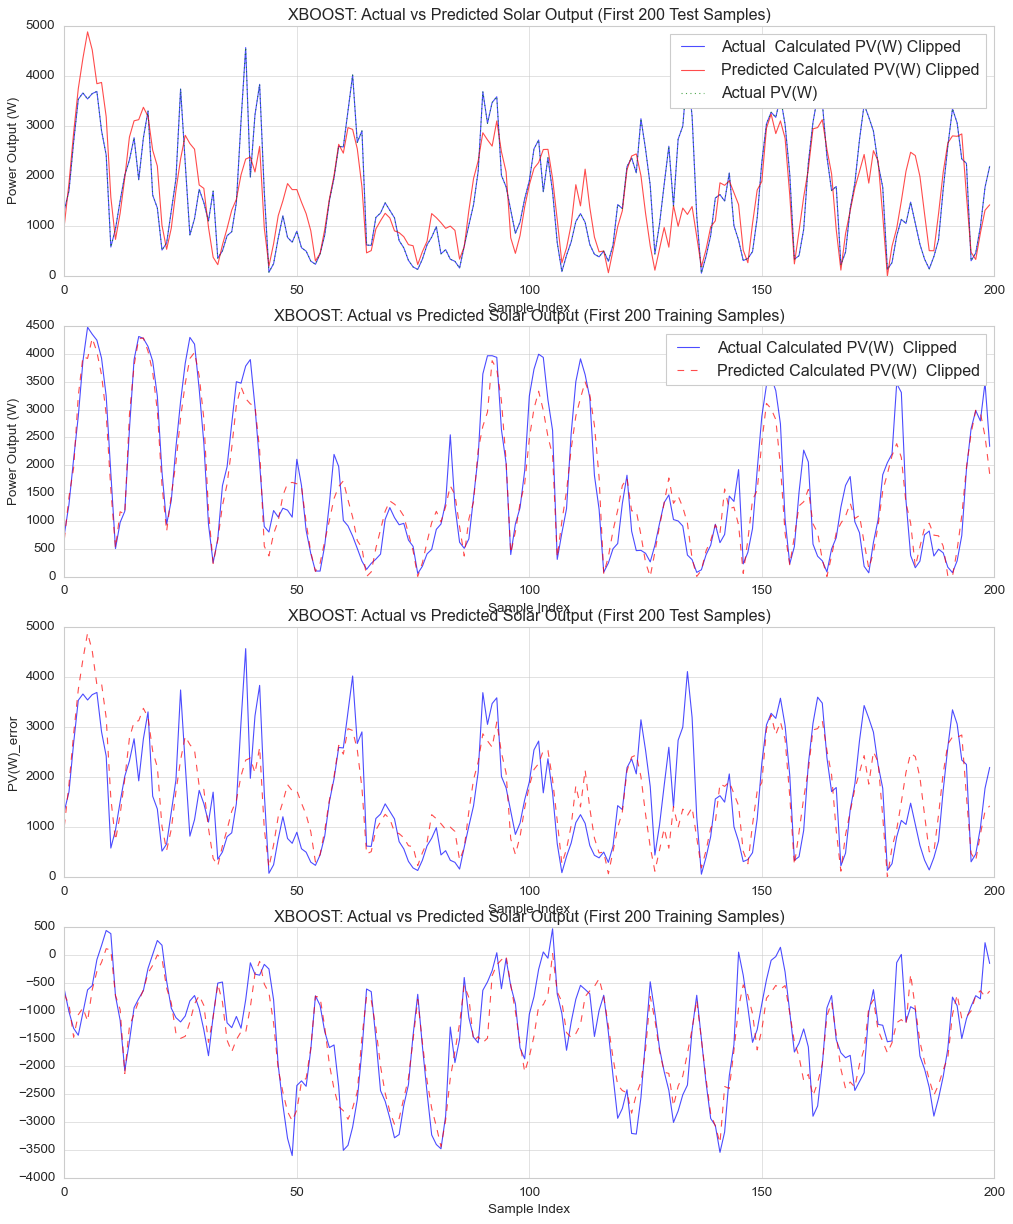

In [26]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test_pvw[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pvw_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    #ax[2].legend()
    #ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    #ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    #ax[2].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    #ax[2].set_xlabel('Sample Index')
    #ax[2].set_ylabel(target_col)
    #ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('XBOOST: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

This is to investigate if using the median as an alternative to mean gives a better result.


Note: Gemini Prompt to generate the code

Investigate what the impact to clipping is on the MAE , RMSE and R2

Write results to CSV file

In [27]:
with open(f'results/xgboost_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/xgboost_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("XGBoost Regressor Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}")
    line.append(f"{test_n_mae*100:.4f}")
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}")
    line.append(f"{train_n_mae*100:.4f}")
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}")
    line.append(f"{test_n_mae_pvw*100:.4f}")
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}")
    line.append(f"{train_n_mae_pvw*100:.4f}")
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')


## Acronyms and Terminology Reference

| Acronym | Full Term | Brief Explanation |
|---------|-----------|-------------------|
| XGBoost | Extreme Gradient Boosting | A machine learning algorithm that builds an ensemble of decision trees sequentially, each correcting errors from previous trees. |
| MAE | Mean Absolute Error | The average absolute difference between predicted and actual values; measures prediction accuracy in original units. |
| RMSE | Root Mean Squared Error | The square root of the average squared differences between predicted and actual values; penalizes larger errors more heavily than MAE. |
| R² | Coefficient of Determination | A metric ranging from 0 to 1 that indicates the proportion of variance in the target variable explained by the model. |
| nRMSE | Normalized Root Mean Squared Error | RMSE divided by a normalization factor (typically the mean of actual values); expressed as a percentage. |
| nMAE | Normalized Mean Absolute Error | MAE divided by a normalization factor (typically the mean of actual values); expressed as a percentage. |
| PV(W) | Photovoltaic Power Output (Watts) | The actual electrical power generated by the solar panel system. |
| PVLIB | PV (Photovoltaic) Library | A Python library for simulating photovoltaic system performance and calculating theoretical solar irradiance. |
| GHI | Global Horizontal Irradiance | The total solar radiation received on a horizontal surface from all directions (direct + diffuse). |
| BHI | Beam Horizontal Irradiance | The direct solar radiation received on a horizontal surface from the solar disk. |
| DHI | Diffuse Horizontal Irradiance | The scattered solar radiation on a horizontal surface from the sky (not directly from the sun). |
| BNI | Beam Normal Irradiance | Direct solar radiation received on a surface perpendicular to the sun's rays. |
| POA | Plane of Array | The plane of the solar panel surface; POA irradiance is the solar radiation hitting the tilted panel. |
| POAC | Plane of Array Clearsky | Theoretical POA irradiance under clear-sky conditions (no clouds). |
| TOA | Top of Atmosphere | Solar radiation at Earth's outer atmosphere before atmospheric attenuation. |
| CV | Cross-Validation | A resampling technique that splits data into k folds to evaluate model performance robustly. |
| SQL | Structured Query Language | Language used to query and manage relational databases. |
| CSV | Comma-Separated Values | A simple text format for storing tabular data with comma delimiters. |
| CI | Confidence Interval | A range of values estimated to contain the true value with a specified probability. |
| LSTM | Long Short-Term Memory | A recurrent neural network architecture designed to capture long-term dependencies in sequential data. |
| ESB | Electricity Supply Board | Ireland's primary electricity utility (context: data source in this project). |